# Capstone Projekt Rossmann

# Predictive Modeling

## Selection of models that will be tested to predict the sales of Rossmann stores

Linear Regression Models:

Linear Regression: If the relationship between the predictors and the sales is linear, linear regression can be a good starting point.
Ridge/Lasso Regression: These are variations of linear regression that include regularization to prevent overfitting, especially useful if you have many predictors.
Tree-based Models:

Decision Trees: Good for capturing non-linear relationships but can overfit.
Random Forest: An ensemble of decision trees, it is more robust and less likely to overfit than a single decision tree.
Gradient Boosting Machines (GBM): Models like Gradient Boosting Regressor or XGBoost, LightGBM, and CatBoost are powerful for capturing complex patterns in data.
Support Vector Machines (SVM):

SVR (Support Vector Regression): Effective in high-dimensional spaces and with kernel functions, it can capture complex relationships.
Nearest Neighbors:

K-Nearest Neighbors (KNN): Can be used for regression; it predicts the value based on the 'k' closest points.
Time Series Specific Models (Not in Scikit-learn but worth considering):

ARIMA/SARIMA: Traditional time series models suitable for univariate time series.
Prophet: Developed by Facebook, good for daily data with multiple seasonality and holiday effects.
LSTM/GRU (Deep Learning): RNNs like LSTM or GRU can be effective, especially if you have a large amount of historical data.

- Linear Regression Models:  
	- Linear Regression
	- Ridge Regression
	- Lasso Regression

- Tree-based Models:
	- Decision Trees
	- Random Forest
	- Gradient Boosting Machines (GBM) (in scikit-learn: GradientBoostingRegressor)

- Support Vector Machines (SVM):
	- SVR (Support Vector Regression)

- Nearest Neighbors:
	- K-Nearest Neighbors (KNN)

- Neural Networks:
	- MLP (Multi-layer Perceptron)

- Time Series Specific Models:
	- ARIMA/SARIMA
	- Prophet
	- LSTM/GRU (Deep Learning)


I want to use:
- LinearRegression
- RidgeRegression
- LassoRegression
- DecisionTreeRegressor
- RandomForestRegressor
- GradiantBoostingRegressor
- SVR
- KNN
- MLPRegressor


## Definition of KPIs for model evaluation

- Mean Absolute Error (MAE): The average of the absolute differences between predictions and actual values. It gives an idea of the magnitude of the error, but no information about the direction (over or under predicting).
- Mean Squared Error (MSE): The average of the squared differences between predictions and actual values. It gives more weight to larger errors and is more useful in practice than MAE.
- Root Mean Squared Error (RMSE): The square root of the MSE, it is more interpretable than the MSE as it is in the same units as the response variable.
- R-squared (R2): The proportion of the variance in the dependent variable that is predictable from the independent variables. It provides an indication of the goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.
- Adjusted R-squared: The R-squared value adjusted for the number of predictors in the model. It is useful for comparing models with different numbers of predictors.


## Functions needed for testing

### Test models with test and tain data. Test includes the last 8 weeks from each store

In [33]:
## Test models with test and tain data. Test includes the last 8 weeks from each store

def testModelsTestSplit8W(df, scaler):
	train_data = []
	test_data = []

	# Group by store and split into training and test data
	amount_test_weeks = 8
	for store_id, group in df.groupby('Store'):
		train_data.append(group[: -amount_test_weeks])
		test_data.append(group[-amount_test_weeks:])

	# Combine the list entries to one dataframe
	train_df = pd.concat(train_data)
	test_df = pd.concat(test_data)

	# Create feature and target data frames
	X_train = train_df.drop(columns=['Future_Sales'])
	y_train = train_df['Future_Sales']
	X_test = test_df.drop(columns=['Future_Sales'])
	y_test = test_df['Future_Sales']

	# Scaling of the data
	if scaler:
		X_train = scaler.fit_transform(X_train)
		X_test = scaler.transform(X_test)

	def adj_r2_score(model, X, y):
		n = X.shape[0]
		p = X.shape[1]
		r2 = r2_score(y, model.predict(X))
		return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

	# Defining the models to test
	models = [
		('LinearRegression', LinearRegression(n_jobs=-1)),
		('RidgeRegression', Ridge(random_state=42)),
		('LassoRegression', Lasso(random_state=42)),
		('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42)),
		('RandomForestRegressor', RandomForestRegressor(n_jobs=-1, max_depth=10, random_state=42, n_estimators=100)),
		#('SVR', SVR()),
		#('KNN', KNeighborsRegressor())
	]

	results = []
	# Train models and calculate metrics
	for name, model in models:
		model.fit(X_train, y_train)
		y_train_pred = model.predict(X_train)
		y_test_pred = model.predict(X_test)

		results.append({
			'Model': name,
			'RMSE_Train': sqrt(mse(y_train, y_train_pred)),
			'MAE_Train': mae(y_train, y_train_pred),
			'R2_Train': r2_score(y_train, y_train_pred),
			'Adj_R2_Train': adj_r2_score(model, X_train, y_train),
			'RMSE_Test': sqrt(mse(y_test, y_test_pred)),
			'MAE_Test': mae(y_test, y_test_pred),
			'R2_Test': r2_score(y_test, y_test_pred),
			'Adj_R2_Test': adj_r2_score(model, X_test, y_test)
		})
		#print last result
		print(results[-1])

	results_df = pd.DataFrame(results)
	return results_df

### Creates x splits in test and train where the last 8 weeks of each store are included in the respective test split and the splits are distributed evenly using gap

In [2]:
#Creates x splits in test and train where the last 8 weeks of each store are included in the respective test split and the splits are distributed
# evenly using gap

def testModelsCV8W(df, scaler):

    n_splits = 5
    window_size = 8
    total_weeks =109
    train_size = window_size / 0.2
    gap = int((total_weeks - window_size - train_size) // (n_splits))

    results = []

    for split in range(n_splits):
        train_data = []
        test_data = []

        for store_id, group in df.groupby('Store'):
            # calculate start and end index for test data
            if split == 0:
                test_start_index = -window_size
                test_df_store = group[test_start_index:]  # Kein Endindex für den ersten Split
            else:
                test_start_index = -(window_size + gap * split)
                test_end_index = test_start_index + window_size
                test_df_store = group[test_start_index:test_end_index]
                print("test:", test_df_store.shape, "Test Start Index:", test_start_index, "Test End Index:", test_end_index)
            
            train_start_index = -int(-test_start_index + gap + train_size)
            train_df_store = group[train_start_index:test_start_index]
            print("Train:", train_df_store.shape, "Train Start Index:", train_start_index, "Train End Index:", test_start_index)
            # Check if test set contains data
            if not test_df_store.empty:
                train_data.append(train_df_store)
                test_data.append(test_df_store)
            else:
                print(f"Store {store_id} has not enough data for splitting {split}")

        # Combine the list entries to one dataframe
        train_df_combined = pd.concat(train_data)
        test_df_combined = pd.concat(test_data)

        # Create feature and target data frames
        X_train = train_df_combined.drop(columns=['Future_Sales'])
        y_train = train_df_combined['Future_Sales']
        X_test = test_df_combined.drop(columns=['Future_Sales'])
        y_test = test_df_combined['Future_Sales']

        # Scaling of the data
        if scaler:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        def adj_r2_score(model, X, y):
            n = X.shape[0]
            p = X.shape[1]
            r2 = r2_score(y, model.predict(X))
            return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

    	# Defining the models to test
        models = [
            ('LinearRegression', LinearRegression(n_jobs=-1)),
            #('RidgeRegression', Ridge(random_state=42)),
            #('LassoRegression', Lasso(random_state=42)),
            #('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42)),
            #('RandomForestRegressor', RandomForestRegressor(n_jobs=-1, max_depth=10, random_state=42, n_estimators=100)),
            #('SVR', SVR()),
            #('KNN', KNeighborsRegressor())
        ]
        
        # Train models and calculate metrics
        for name, model in models:
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
        
            results.append({
                'Model': name,
                'RMSE_Train': sqrt(mse(y_train, y_train_pred)),
                'MAE_Train': mae(y_train, y_train_pred),
                'R2_Train': r2_score(y_train, y_train_pred),
                'Adj_R2_Train': adj_r2_score(model, X_train, y_train),
                'RMSE_Test': sqrt(mse(y_test, y_test_pred)),
                'MAE_Test': mae(y_test, y_test_pred),
                'R2_Test': r2_score(y_test, y_test_pred),
                'Adj_R2_Test': adj_r2_score(model, X_test, y_test)
            })
            #print last result
            print(results[-1])

    results_df = pd.DataFrame(results)

    # calculate mean of all splits
    model_list = results_df['Model'].unique()
    # create resulte_mean_df
    resulte_mean_df = pd.DataFrame(columns=results_df.columns)
    # iterate over model_list
    for model in model_list:
        # get mean of each model
        mean = results_df[results_df['Model'] == model].mean(numeric_only=True)
        mean['Model'] = model
        # append mean to resulte_mean_df
        resulte_mean_df = pd.concat([resulte_mean_df, pd.DataFrame([mean], columns=results_df.columns)], ignore_index=True)

    return results_df, resulte_mean_df


### Function to create a model for single store forecast

In [34]:
## Test models with test and tain data. Test includes the last 8 weeks from each store


def storeForecastTestSplit8W(df, scaler):
	train_data = []
	test_data = []

	# Group by store and split into training and test data
	amount_test_weeks = 8
	for store_id, group in df.groupby('Store'):
		train_data.append(group[: -amount_test_weeks])
		test_data.append(group[-amount_test_weeks:])

	# Combine the list entries to one dataframe
	train_df = pd.concat(train_data)
	test_df = pd.concat(test_data)

	# Create feature and target data frames
	X_train = train_df.drop(columns=['Future_Sales'])
	y_train = train_df['Future_Sales']
	X_test = test_df.drop(columns=['Future_Sales'])
	y_test = test_df['Future_Sales']

	# Scaling of the data
	if scaler:
		X_train = scaler.fit_transform(X_train)
		X_test = scaler.transform(X_test)

	# Defining the models to test
	model = LinearRegression(n_jobs=-1)
 
	# Train models and calculate metrics
	model.fit(X_train, y_train)
	return model, scaler

## Performance Reference (rolling mean)

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pandas.api.types import infer_dtype

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score
from math import sqrt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import RobustScaler

pd.set_option('display.max_columns', None)

In [35]:
df = pd.read_csv('df_nans_handeled_cat_power.csv')

### Performance Reference with one model for all stores

In [6]:
amount_test_weeks = 8
rolling_mean_weeks = 4

model, scaler = storeForecastTestSplit8W(df, MinMaxScaler())
results_diff_model = []
results_diff_mean = []

for store_id in df['Store'].unique():
	df_store = df[df['Store'] == store_id]

	# Split into training and test data unsing the last 8 weeks
	train_df = df_store[: -amount_test_weeks]
	test_df = df_store[-amount_test_weeks:]

	# Create feature and target data frames
	X_train = train_df.drop(columns=['Future_Sales'])
	y_train = train_df['Future_Sales']
	X_test = test_df.drop(columns=['Future_Sales'])
	y_test = test_df['Future_Sales']

	# Scaling of the data
	X_train = scaler.transform(X_train)
	X_test = scaler.transform(X_test)

	y_train_pred = model.predict(X_train)
	y_test_pred = model.predict(X_test)

	# Convert predictions to pandas Series
	y_train_pred_series = pd.Series(y_train_pred, index=y_train.index, name='y_train_pred')
	y_test_pred_series = pd.Series(y_test_pred, index=y_test.index, name='y_test_pred')

	# Combine the predictions and actuals into one DataFrame
	combined_df = pd.concat([y_train, y_train_pred_series, y_test, y_test_pred_series], axis=1)

	# Optional: Fill NaN values if you want to clean up the resulting DataFrame
	# This is helpful because y_train/y_train_pred will have NaNs for the y_test/y_test_pred indices and vice versa
	#combined_df = combined_df.fillna('-')

	#combined_df['neue_spalte'] = np.where(pd.notnull(combined_df[0]), combined_df[0], combined_df[2])
	combined_df['Future_Sales_comb'] = df_store = df[df['Store'] == store_id]['Future_Sales']

	combined_df['Future_Sales_rolling_mean'] = combined_df['Future_Sales_comb'].rolling(rolling_mean_weeks).mean()

	# Calculate difference of wrong prediction
	combined_df['Diff_model'] = combined_df['y_test_pred'] - combined_df['Future_Sales_comb']
	#combined_df['Diff_mean'] = combined_df['Future_Sales_rolling_mean'] - combined_df['Future_Sales_comb']
	combined_df['Diff_mean'] = np.where(
	    combined_df['y_test_pred'].notna(),
	    combined_df['Future_Sales_rolling_mean'] - combined_df['Future_Sales_comb'],
	    np.nan
	)
 
	results_diff_model.append(abs(combined_df['Diff_model']).mean())
	results_diff_mean.append(abs(combined_df['Diff_mean']).mean())

 
print("meand of Diff_model:", np.mean(results_diff_model))
print("meand of Diff_mean:", np.mean(results_diff_mean))

meand of Diff_model: 4395.438901345292
meand of Diff_mean: 5694.444366591928


#### Performance Reference with own model for each store

In [36]:
amount_test_weeks = 8
rolling_mean_weeks = 4

results_diff_model = []
results_diff_mean = []

for store_id in df['Store'].unique():
	df_store = df[df['Store'] == store_id]
	model, scaler = storeForecastTestSplit8W(df_store, MinMaxScaler())

	# Split into training and test data unsing the last 8 weeks
	train_df = df_store[: -amount_test_weeks]
	test_df = df_store[-amount_test_weeks:]

	# Create feature and target data frames
	X_train = train_df.drop(columns=['Future_Sales'])
	y_train = train_df['Future_Sales']
	X_test = test_df.drop(columns=['Future_Sales'])
	y_test = test_df['Future_Sales']

	# Scaling of the data
	X_train = scaler.transform(X_train)
	X_test = scaler.transform(X_test)

	y_train_pred = model.predict(X_train)
	y_test_pred = model.predict(X_test)

	# Convert predictions to pandas Series
	y_train_pred_series = pd.Series(y_train_pred, index=y_train.index, name='y_train_pred')
	y_test_pred_series = pd.Series(y_test_pred, index=y_test.index, name='y_test_pred')

	# Combine the predictions and actuals into one DataFrame
	combined_df = pd.concat([y_train, y_train_pred_series, y_test, y_test_pred_series], axis=1)

	# Optional: Fill NaN values if you want to clean up the resulting DataFrame
	# This is helpful because y_train/y_train_pred will have NaNs for the y_test/y_test_pred indices and vice versa
	#combined_df = combined_df.fillna('-')

	#combined_df['neue_spalte'] = np.where(pd.notnull(combined_df[0]), combined_df[0], combined_df[2])
	combined_df['Future_Sales_comb'] = df_store = df[df['Store'] == store_id]['Future_Sales']

	combined_df['Future_Sales_rolling_mean'] = combined_df['Future_Sales_comb'].rolling(rolling_mean_weeks).mean()

	# Calculate difference of wrong prediction
	combined_df['Diff_model'] = combined_df['y_test_pred'] - combined_df['Future_Sales_comb']
	#combined_df['Diff_mean'] = combined_df['Future_Sales_rolling_mean'] - combined_df['Future_Sales_comb']
	combined_df['Diff_mean'] = np.where(
	    combined_df['y_test_pred'].notna(),
	    combined_df['Future_Sales_rolling_mean'] - combined_df['Future_Sales_comb'],
	    np.nan
	)
 
	results_diff_model.append(abs(combined_df['Diff_model']).mean())
	results_diff_mean.append(abs(combined_df['Diff_mean']).mean())

 
print("meand of Diff_model:", np.mean(results_diff_model))
print("meand of Diff_mean:", np.mean(results_diff_mean))

meand of Diff_model: 117980464215323.52
meand of Diff_mean: 5694.444366591928


**Result:**  
- The MAE of the simple mean forecast by rolling 4 weeks is 5694
- The MAE of the model forecast is 4395
-> The model forecast is better (1299€/ -23%) then the simple mean forecast


## Pre-Test of different Models

In [49]:
df = pd.read_csv('df_nans_handeled_cat_power.csv')

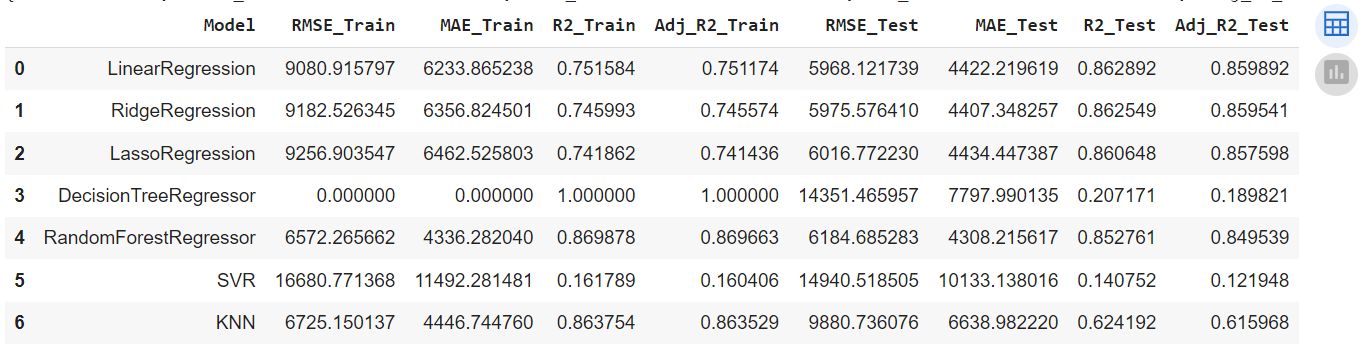

In [8]:
# show stored png
from IPython.display import Image
Image('C:\\Users\\Chris\\OneDrive\\Arbeitslos\\Data Scientist\\7 Capstone Projekt - Ein Machine Learning Projekt von A bis Z\\Results - Test of 6 Models.png')


In [9]:
pd.set_option('display.max_rows', 10000)

In [10]:
df.isna().sum()

Store                             0
CW                                0
Month                             0
Year                              0
Open                              0
Promo                             0
IsPromo                           0
IsStateHoliday                    0
SchoolHoliday                     0
IsSchoolHoliday                   0
NumStateHoliday                   0
CompetitionDistance               0
IsCompetition                     0
Promo2                            0
Promo2Member                      0
Promo2Active                      0
StateHoliday_0                    0
StateHoliday_a                    0
StateHoliday_b                    0
StateHoliday_c                    0
StoreType_a                       0
StoreType_b                       0
StoreType_c                       0
StoreType_d                       0
Assortment_a                      0
Assortment_b                      0
Assortment_c                      0
PromoInterval_0             

In [11]:
testModelsTestSplit8W(df, MinMaxScaler())

{'Model': 'LinearRegression', 'RMSE_Train': 9081.178921413037, 'MAE_Train': 6229.184072093825, 'R2_Train': 0.7515692210307627, 'Adj_R2_Train': 0.7511593471555716, 'RMSE_Test': 5941.163691018397, 'MAE_Test': 4395.438901345292, 'R2_Test': 0.8641279045091326, 'Adj_R2_Test': 0.8611545348667453}
{'Model': 'RidgeRegression', 'RMSE_Train': 9182.526345171846, 'MAE_Train': 6356.824500652021, 'R2_Train': 0.7459932239237583, 'Adj_R2_Train': 0.7455741504817833, 'RMSE_Test': 5975.576410017011, 'MAE_Test': 4407.348257027391, 'R2_Test': 0.8625493350622819, 'Adj_R2_Test': 0.8595414206485441}


**Linear Regression Coefficients:**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124880 entries, 0 to 124879
Columns: 192 entries, Store to Future_Sales
dtypes: float64(177), int64(15)
memory usage: 182.9 MB


In [8]:
train_data = []
test_data = []
# Group by store and split into training and test data
amount_test_weeks = 8
for store_id, group in df.groupby('Store'):
	train_data.append(group[: -amount_test_weeks])
	test_data.append(group[-amount_test_weeks:])
# Combine the list entries to one dataframe
train_df = pd.concat(train_data)
test_df = pd.concat(test_data)
# Create feature and target data frames
X_train = train_df.drop(columns=['Future_Sales'])
y_train = train_df['Future_Sales']
X_test = test_df.drop(columns=['Future_Sales'])
y_test = test_df['Future_Sales']

# Scaling of the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Defining the models to test
model = Ridge()#(n_jobs=-1)

# Train models and calculate metrics
model.fit(X_train, y_train)

feature_names = df.drop(columns=['Future_Sales']).columns

# Zugriff auf die Koeffizienten
coefficients = model.coef_

# Erstellen eines DataFrames zur besseren Visualisierung der Feature-Wichtigkeiten
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient'])

# Sortieren der Features nach ihrer Wichtigkeit (absoluter Wert des Koeffizienten)
feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)

feature_importance

## Visualisiere die Verteilung
#X_train_df = pd.DataFrame(X_train, columns=feature_names)
#X_test_df = pd.DataFrame(X_test, columns=feature_names)
#
## Erstellen von Histogrammen für die ersten paar Features zur Demonstration
#num_features_to_plot = 50  # Anpassen, um mehr oder weniger Features zu visualisieren
#for feature in feature_names[:num_features_to_plot]:
#    plt.figure(figsize=(10, 4))
#
#    # Histogramm für das Training-Set
#    plt.subplot(1, 2, 1)
#    plt.hist(X_train_df[feature], bins=20, alpha=0.7)
#    plt.title(f'Train - {feature}')
#
#    # Histogramm für das Test-Set
#    plt.subplot(1, 2, 2)
#    plt.hist(X_test_df[feature], bins=20, alpha=0.7)
#    plt.title(f'Test - {feature}')
#
#    plt.show()


# use SelectPercentile to select the top 50% of features
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# create the selector
selector = SelectPercentile(score_func=f_regression, percentile=50)
#selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold="median")


# fit the selector to the training data
selector.fit(X_train, y_train)

# transform training and test data
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# create a mask to visualize the selected features
mask = selector.get_support()

# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Sample Index')
plt.yticks(())
plt.show()

# get list of selected features
selected_features = feature_names[mask]
selected_features




In [10]:

testModelsTestSplit8W(df[['Store', 'Future_Sales', 'Sales_Lag_1', 'Sales_Lag_1_MA_4', 'Sales_Lag_1_MA_6',
       'Sales_Lag_1_MA_8', 'Sales_Lag_2', 'Sales_Lag_2_MA_4',
       'Sales_Lag_2_MA_6', 'Sales_Lag_2_MA_8', 'Sales_Lag_3',
       'Sales_Lag_3_MA_4', 'Sales_Lag_3_MA_6', 'Sales_Lag_3_MA_8',
       'Sales_Lag_4', 'Sales_Lag_4_MA_4', 'Sales_Lag_4_MA_6',
       'Sales_Lag_4_MA_8', 'Sales_Lag_5', 'Sales_Lag_5_MA_4',
       'Sales_Lag_5_MA_6', 'Sales_Lag_5_MA_8', 'Sales_Lag_6',
       'Sales_Lag_6_MA_4', 'Sales_Lag_6_MA_6', 'Sales_Lag_6_MA_8',
       'Sales_Lag_7', 'Sales_Lag_7_MA_4', 'Sales_Lag_7_MA_6',
       'Sales_Lag_7_MA_8', 'Sales_Lag_8_MA_4', 'Sales_Lag_8_MA_6',
       'Sales_Lag_8_MA_8', 'SalesPerOpenDay_Lag_1',
       'SalesPerOpenDay_Lag_1_MA_4', 'SalesPerOpenDay_Lag_1_MA_6',
       'SalesPerOpenDay_Lag_1_MA_8', 'SalesPerOpenDay_Lag_2',
       'SalesPerOpenDay_Lag_2_MA_4', 'SalesPerOpenDay_Lag_2_MA_6',
       'SalesPerOpenDay_Lag_2_MA_8', 'SalesPerOpenDay_Lag_3',
       'SalesPerOpenDay_Lag_3_MA_4', 'SalesPerOpenDay_Lag_3_MA_6',
       'SalesPerOpenDay_Lag_3_MA_8', 'SalesPerOpenDay_Lag_4_MA_4',
       'SalesPerOpenDay_Lag_4_MA_6', 'SalesPerOpenDay_Lag_4_MA_8',
       'SalesPerOpenDay_Lag_5', 'SalesPerOpenDay_Lag_5_MA_4',
       'SalesPerOpenDay_Lag_5_MA_6', 'SalesPerOpenDay_Lag_5_MA_8',
       'SalesPerOpenDay_Lag_6_MA_4', 'SalesPerOpenDay_Lag_6_MA_6',
       'SalesPerOpenDay_Lag_6_MA_8', 'SalesPerOpenDay_Lag_7_MA_4',
       'SalesPerOpenDay_Lag_7_MA_6', 'SalesPerOpenDay_Lag_7_MA_8',
       'SalesPerOpenDay_Lag_8_MA_4', 'SalesPerOpenDay_Lag_8_MA_6',
       'SalesPerOpenDay_Lag_8_MA_8', 'Customers_Lag_1', 'Customers_Lag_1_MA_4',
       'Customers_Lag_1_MA_6', 'Customers_Lag_1_MA_8', 'Customers_Lag_2',
       'Customers_Lag_2_MA_4', 'Customers_Lag_2_MA_6', 'Customers_Lag_3',
       'Customers_Lag_5', 'Customers_Lag_7', 'CustomersPerOpenDay_Lag_1',
       'CustomersPerOpenDay_Lag_1_MA_4', 'CustomersPerOpenDay_Lag_1_MA_6',
       'CustomersPerOpenDay_Lag_1_MA_8', 'CustomersPerOpenDay_Lag_2',
       'CustomersPerOpenDay_Lag_2_MA_4', 'CustomersPerOpenDay_Lag_2_MA_6',
       'CustomersPerOpenDay_Lag_2_MA_8', 'CustomersPerOpenDay_Lag_3',
       'CustomersPerOpenDay_Lag_3_MA_4', 'CustomersPerOpenDay_Lag_3_MA_6',
       'CustomersPerOpenDay_Lag_3_MA_8', 'CustomersPerOpenDay_Lag_4',
       'CustomersPerOpenDay_Lag_4_MA_4', 'CustomersPerOpenDay_Lag_4_MA_6',
       'CustomersPerOpenDay_Lag_4_MA_8', 'CustomersPerOpenDay_Lag_5',
       'CustomersPerOpenDay_Lag_5_MA_4', 'CustomersPerOpenDay_Lag_5_MA_6',
       'CustomersPerOpenDay_Lag_5_MA_8', 'CustomersPerOpenDay_Lag_6_MA_4',
       'CustomersPerOpenDay_Lag_6_MA_6', 'CustomersPerOpenDay_Lag_6_MA_8',
       'CustomersPerOpenDay_Lag_7_MA_4', 'CustomersPerOpenDay_Lag_7_MA_6',
       'CustomersPerOpenDay_Lag_8_MA_4']], MinMaxScaler())

{'Model': 'LinearRegression', 'RMSE_Train': 10314.90459994385, 'MAE_Train': 7121.688650653756, 'R2_Train': 0.6794827797639779, 'Adj_R2_Train': 0.6792698059979212, 'RMSE_Test': 6537.731917951399, 'MAE_Test': 4878.064247751744, 'R2_Test': 0.8354713806450278, 'Adj_R2_Test': 0.8340385935278221}
{'Model': 'RidgeRegression', 'RMSE_Train': 10383.971553776046, 'MAE_Train': 7222.649460842235, 'R2_Train': 0.6751761453707659, 'Adj_R2_Train': 0.6749603099795364, 'RMSE_Test': 6422.203519171591, 'MAE_Test': 4791.909705605473, 'R2_Test': 0.8412347815317567, 'Adj_R2_Test': 0.8398521846281088}


c:\Users\Chris\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.143e+12, tolerance: 3.849e+09
  model = cd_fast.enet_coordinate_descent(


{'Model': 'LassoRegression', 'RMSE_Train': 10445.62988580238, 'MAE_Train': 7303.4019865052, 'R2_Train': 0.6713071904599817, 'Adj_R2_Train': 0.67108878426804, 'RMSE_Test': 6274.401418415809, 'MAE_Test': 4669.937004136659, 'R2_Test': 0.8484584108210865, 'Adj_R2_Test': 0.8471387204380537}
{'Model': 'DecisionTreeRegressor', 'RMSE_Train': 2267.6263693732076, 'MAE_Train': 240.91147090950898, 'R2_Train': 0.9845095535953698, 'Adj_R2_Train': 0.984499260673491, 'RMSE_Test': 13749.15072439576, 'MAE_Test': 9047.935650224215, 'R2_Test': 0.272322439441516, 'Adj_R2_Test': 0.2659855052452931}


## Forecast of single store

In [129]:
store_id =410
amount_test_weeks = 8

model, scaler = storeForecastTestSplit8W(df, MinMaxScaler())

df_store = df[df['Store'] == store_id]

# Split into training and test data unsing the last 8 weeks
train_df = df_store[: -amount_test_weeks]
test_df = df_store[-amount_test_weeks:]

# Create feature and target data frames
X_train = train_df.drop(columns=['Future_Sales'])
y_train = train_df['Future_Sales']
X_test = test_df.drop(columns=['Future_Sales'])
y_test = test_df['Future_Sales']

# Scaling of the data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

def adj_r2_score(model, X, y):
		n = X.shape[0]
		p = X.shape[1]
		r2 = r2_score(y, model.predict(X))
		return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

results = []	
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
results.append({
	'RMSE_Train': sqrt(mse(y_train, y_train_pred)),
	'MAE_Train': mae(y_train, y_train_pred),
	'R2_Train': r2_score(y_train, y_train_pred),
	'Adj_R2_Train': adj_r2_score(model, X_train, y_train),
	'RMSE_Test': sqrt(mse(y_test, y_test_pred)),
	'MAE_Test': mae(y_test, y_test_pred),
	'R2_Test': r2_score(y_test, y_test_pred),
	'Adj_R2_Test': adj_r2_score(model, X_test, y_test)
})
#print last result
print(results[-1])

results_df = pd.DataFrame(results)
results_df


{'RMSE_Train': 7412.548670874068, 'MAE_Train': 6189.298076923077, 'R2_Train': 0.3175753705370258, 'Adj_R2_Train': 1.798747009485072, 'RMSE_Test': 5418.570129655978, 'MAE_Test': 4894.25, 'R2_Test': 0.5547784206044921, 'Adj_R2_Test': 1.016937777477003}


,RMSE_Train,MAE_Train,R2_Train,Adj_R2_Train,RMSE_Test,MAE_Test,R2_Test,Adj_R2_Test
0,7412.548671,6189.298077,0.317575,1.798747,5418.57013,4894.25,0.554778,1.016938


In [126]:
# Convert predictions to pandas Series
y_train_pred_series = pd.Series(y_train_pred, index=y_train.index, name='y_train_pred')
y_test_pred_series = pd.Series(y_test_pred, index=y_test.index, name='y_test_pred')

# Combine the predictions and actuals into one DataFrame
combined_df = pd.concat([y_train, y_train_pred_series, y_test, y_test_pred_series], axis=1)

# Optional: Fill NaN values if you want to clean up the resulting DataFrame
# This is helpful because y_train/y_train_pred will have NaNs for the y_test/y_test_pred indices and vice versa
#combined_df = combined_df.fillna('-')

#combined_df['neue_spalte'] = np.where(pd.notnull(combined_df[0]), combined_df[0], combined_df[2])
combined_df['Future_Sales_comb'] = df_store = df[df['Store'] == store_id]['Future_Sales']

rolling_mean_weeks = 4
combined_df['Future_Sales_rolling_mean'] = combined_df['Future_Sales_comb'].rolling(rolling_mean_weeks).mean()

# Calculate difference of wrong prediction
combined_df['Diff_model'] = combined_df['y_test_pred'] - combined_df['Future_Sales_comb']
#combined_df['Diff_mean'] = combined_df['Future_Sales_rolling_mean'] - combined_df['Future_Sales_comb']
combined_df['Diff_mean'] = np.where(
    combined_df['y_test_pred'].notna(),
    combined_df['Future_Sales_rolling_mean'] - combined_df['Future_Sales_comb'],
    np.nan
)

print("meand of Diff_model:", abs(combined_df['Diff_model']).mean())
print("meand of Diff_mean:", abs(combined_df['Diff_mean']).mean())

# View the combined DataFrame
combined_df


meand of Diff_model: 4894.25
meand of Diff_mean: 7602.6875


,Future_Sales,y_train_pred,Future_Sales,y_test_pred,Future_Sales_comb,Future_Sales_rolling_mean,Diff_model,Diff_mean
45808,28307.0,36564.0,NaN,NaN,28307.0,NaN,NaN,NaN
45809,38065.0,38356.0,NaN,NaN,38065.0,NaN,NaN,NaN
45810,29105.0,35700.0,NaN,NaN,29105.0,NaN,NaN,NaN
45811,44933.0,37170.0,NaN,NaN,44933.0,35102.50,NaN,NaN
45812,29133.0,35602.0,NaN,NaN,29133.0,35309.00,NaN,NaN
45813,46847.0,38546.0,NaN,NaN,46847.0,37504.50,NaN,NaN
45814,25174.0,32942.0,NaN,NaN,25174.0,36521.75,NaN,NaN
45815,47336.0,40336.0,NaN,NaN,47336.0,37122.50,NaN,NaN
45816,28023.0,36620.0,NaN,NaN,28023.0,36845.00,NaN,NaN
45817,42604.0,32052.0,NaN,NaN,42604.0,35784.25,NaN,NaN


## Model Per Store

### Prophet

In [44]:
from prophet import Prophet
df = pd.read_csv('weekly_sales_with_store_info.csv')
df['Date'] = pd.to_datetime(df['Date'])


19:03:24 - cmdstanpy - INFO - Chain [1] start processing
19:03:24 - cmdstanpy - INFO - Chain [1] done processing


Mean of Diff_model: 1757.8856327062886


,yhat,yhat_lower,yhat_upper,y
ds,,,,
2015-06-14,22239.142802,19380.799624,24879.130934,22745
2015-06-21,28301.516823,25358.833090,31122.340239,27357
2015-06-28,23478.000017,20584.546605,26393.436302,22344
2015-07-05,28985.488262,26047.359754,31922.902385,31398
2015-07-12,24772.934640,21457.851426,27538.694551,26352
2015-07-19,31942.275183,28982.256297,34954.879560,30955
2015-07-26,28919.860070,25845.013335,31782.701516,26264
2015-08-02,28226.001327,25136.140651,31142.351479,32070


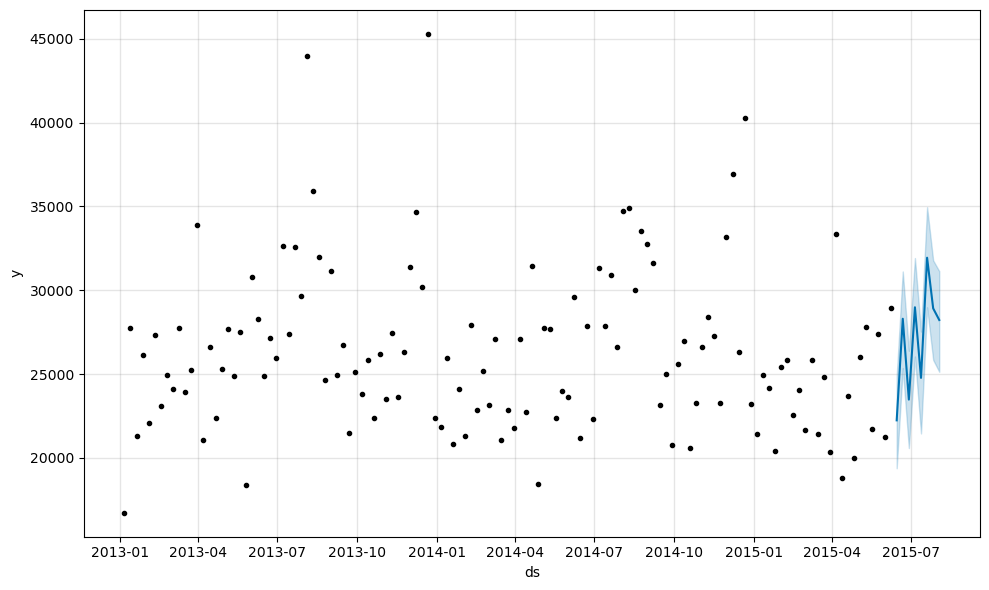

In [45]:
df_store = df[df['Store'] == 110]
df_store = df_store[['Date', 'Sales', 'IsPromo', 'IsStateHoliday', 'NumStateHoliday', 'Open']]

amount_test_weeks = 8
df_prophet = df_store.rename(columns={'Date': 'ds', 'Sales': 'y'})
df_train = df_prophet[: -amount_test_weeks]
df_test = df_prophet[-amount_test_weeks:]#.drop(columns=['y'])


model = Prophet()
model.add_regressor('IsPromo')
model.add_regressor('IsStateHoliday')
model.add_regressor('NumStateHoliday')
model.add_regressor('Open')
model.fit(df_train)

#future = model.make_future_dataframe(periods=8, freq='W')
forecast = model.predict(df_test)
fig = model.plot(forecast)
results = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_test.set_index('ds')['y'])
print("Mean of Diff_model:", abs(results['yhat'] - results['y']).mean())
results

#### Comparing Prophet with the simple mean forecast for all stores

In [48]:
amount_test_weeks = 8
rolling_mean_weeks = 4

df = pd.read_csv('weekly_sales_with_store_info.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Store', 'Date', 'Sales', 'IsPromo', 'IsStateHoliday', 'NumStateHoliday', 'Open']]

results_diff_model = []
results_diff_mean = []

for store_id in df['Store'].unique(): #range(110, 111):
    df_store = df[df['Store'] == store_id]

    # Vorbereitung der Daten
    df_store = df_store.rename(columns={'Date': 'ds', 'Sales': 'y'}).drop(columns=['Store'])
    train_df = df_store[:-amount_test_weeks]
    test_df = df_store[-amount_test_weeks:]
 
    # Prophet-Modell
    model = Prophet()
    model.add_regressor('IsPromo')
    model.add_regressor('IsStateHoliday')
    model.add_regressor('NumStateHoliday')
    model.add_regressor('Open')
    model.fit(train_df)
    forecast = model.predict(test_df)

    # Vorbereitung der Daten für Vergleich
    y_test = test_df['y'].reset_index(drop=True)
    y_test_pred = forecast['yhat'].reset_index(drop=True)

    # Berechnung der rollierenden Mittelwerte auf Basis der Trainingsdaten
    rolling_mean = train_df['y'].rolling(window=rolling_mean_weeks, min_periods=1).mean().iloc[-amount_test_weeks:].reset_index(drop=True)

    # Berechnung der Differenzen
    diff_model = abs(y_test_pred - y_test)
    diff_mean = abs(rolling_mean - y_test)

    results_diff_model.append(diff_model.mean())
    results_diff_mean.append(diff_mean.mean())

print("Mean of Diff_model:", np.mean(results_diff_model))
print("Mean of Diff_mean:", np.mean(results_diff_mean))


19:06:38 - cmdstanpy - INFO - Chain [1] start processing
19:06:38 - cmdstanpy - INFO - Chain [1] done processing
19:06:39 - cmdstanpy - INFO - Chain [1] start processing
19:06:39 - cmdstanpy - INFO - Chain [1] done processing
19:06:39 - cmdstanpy - INFO - Chain [1] start processing
19:06:39 - cmdstanpy - INFO - Chain [1] done processing
19:06:39 - cmdstanpy - INFO - Chain [1] start processing
19:06:39 - cmdstanpy - INFO - Chain [1] done processing
19:06:39 - cmdstanpy - INFO - Chain [1] start processing
19:06:40 - cmdstanpy - INFO - Chain [1] done processing
19:06:40 - cmdstanpy - INFO - Chain [1] start processing
19:06:40 - cmdstanpy - INFO - Chain [1] done processing
19:06:40 - cmdstanpy - INFO - Chain [1] start processing
19:06:40 - cmdstanpy - INFO - Chain [1] done processing
19:06:40 - cmdstanpy - INFO - Chain [1] start processing
19:06:40 - cmdstanpy - INFO - Chain [1] done processing
19:06:41 - cmdstanpy - INFO - Chain [1] start processing
19:06:41 - cmdstanpy - INFO - Chain [1]

Mean of Diff_model: 2595.84282407716
Mean of Diff_mean: 5080.371356502242
